### Notebook para el entrenamiento del modelo

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
import re
import os


In [3]:
df = pd.read_csv('../data/merge_happiness_ohe.csv')

X = df.drop(columns=['Country','Score'])
y = df['Score']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Shape X_train:", X_train.shape)
print("Shape X_test: ", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test: ", y_test.shape)


Shape X_train: (625, 19)
Shape X_test:  (157, 19)
Shape y_train: (625,)
Shape y_test:  (157,)


In [4]:
X = df.drop(columns=['Country','Score'])
y = df['Score']

X.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', str(col)) for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

results = []
predictions_dict = {}
trained_models_dict = {} 

for name, model_instance in models.items():
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    
    predictions_dict[name] = y_pred 
    trained_models_dict[name] = model_instance
    
    results.append({
        'model':        name,
        'r2_score':     r2_score(y_test, y_pred),
        'mae':          mean_absolute_error(y_test, y_pred),
        'mse':          mean_squared_error(y_test, y_pred),
        'rmse':         np.sqrt(mean_squared_error(y_test, y_pred)),
        'explained_variance': explained_variance_score(y_test, y_pred)
    })
    
results_df = pd.DataFrame(results).sort_values('r2_score', ascending=False)
print("\nResultados de los modelos:")
print(results_df)


Resultados de los modelos:
              model  r2_score       mae       mse      rmse  \
6          CatBoost  0.859120  0.316342  0.171363  0.413960   
4           XGBoost  0.829587  0.348888  0.207287  0.455287   
2      RandomForest  0.826059  0.348464  0.211578  0.459976   
3  GradientBoosting  0.816174  0.347142  0.223603  0.472866   
5          LightGBM  0.801359  0.375570  0.241623  0.491551   
0  LinearRegression  0.767345  0.396970  0.282996  0.531974   
1      DecisionTree  0.684737  0.474510  0.383479  0.619257   

   explained_variance  
6            0.859280  
4            0.830323  
2            0.826075  
3            0.816176  
5            0.801809  
0            0.767448  
1            0.684973  


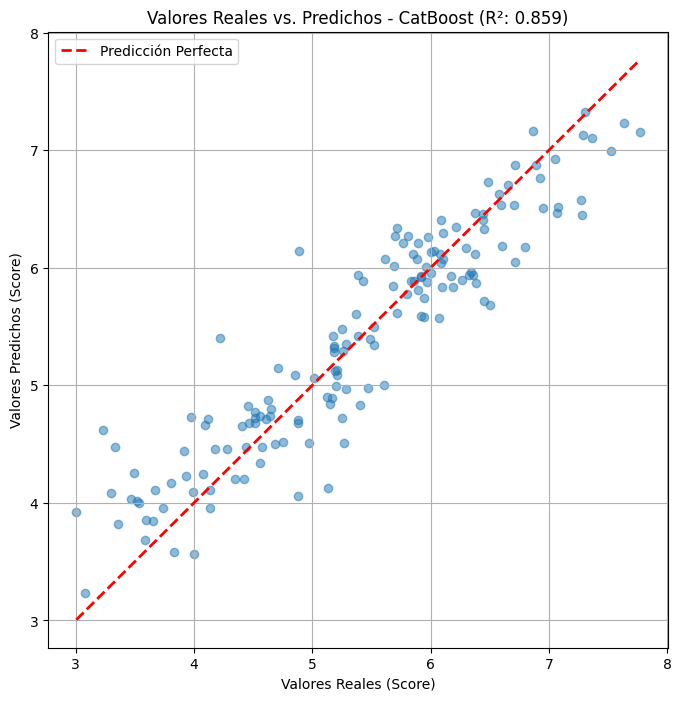

In [5]:
best_model_name = results_df.iloc[0]['model']
best_model_predictions = predictions_dict[best_model_name]

plt.figure(figsize=(8, 8))
plt.scatter(y_test, best_model_predictions, alpha=0.5)
    
min_val = min(y_test.min(), best_model_predictions.min())
max_val = max(y_test.max(), best_model_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Predicción Perfecta')
    
plt.title(f'Valores Reales vs. Predichos - {best_model_name} (R²: {results_df.iloc[0]["r2_score"]:.3f})')
plt.xlabel('Valores Reales (Score)')
plt.ylabel('Valores Predichos (Score)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if best_model_name in trained_models_dict:
    best_model_object = trained_models_dict[best_model_name]

    if hasattr(best_model_object, 'feature_importances_'):
        importances = best_model_object.feature_importances_
    elif hasattr(best_model_object, 'get_feature_importance'): 
        importances = best_model_object.get_feature_importance()
    else:
        importances = None

    if importances is not None:
        feature_names = X_train.columns 
        
        feature_importances_series = pd.Series(importances, index=feature_names)
        feature_importances_sorted = feature_importances_series.sort_values(ascending=False)
        
        print(feature_importances_sorted.head(20))

Economy                                   25.629841
Health                                    15.379177
Freedom                                   12.416037
Trust                                     10.696600
Support                                    9.782839
Region_Latin_America_and_Caribbean         9.296596
Generosity                                 6.595398
Region_Eastern_Asia                        1.566507
Region_Sub_Saharan_Africa                  1.442020
Region_Southern_Asia                       1.380857
Year_2016                                  1.364834
Region_Central_and_Eastern_Europe          1.169339
Year_2017                                  0.803714
Region_Western_Europe                      0.717787
Region_Middle_East_and_Northern_Africa     0.635465
Year_2019                                  0.546394
Year_2018                                  0.402815
Region_Southeastern_Asia                   0.111231
Region_North_America                       0.062551
dtype: float

In [10]:
output_directory = '../data/test_data'
output_filename = 'happiness_test_data.csv'
full_output_path = os.path.join(output_directory, output_filename)
os.makedirs(output_directory, exist_ok=True)

test_indices = X_test.index
countries_test = df.loc[test_indices, 'Country']

test_data_to_save = X_test.copy()
test_data_to_save['Country'] = countries_test
test_data_to_save['Score'] = y_test

test_data_to_save.to_csv(full_output_path, index=False)

### Guardar el modelo

In [ ]:
import pickle

best_model = trained_models_dict['CatBoost']

with open('../model/catboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
